# Am I The A-hole Predictor Project

## Table of contents
- <a href="#intro">Introduction</a>
- <a href="#loading">Loading and assessment</a>
- <a href="#cleaning">Cleaning</a>
- <a href="#overview">General Overview</a>
- <a href="#insights">Insights</a>
- <a href="#discussion">Discussion</a>
- <a href="#tester">Model Tester</a>

<a id="intro"></a>
## Introduction
This project is based on one of Reddit's most popular section: <a href="https://www.reddit.com/r/AmItheAsshole/">r/AmITheAsshole</a>. This subreddit (AITA for short) has a simple premise of having people post about social experiences where they're unsure if they're the one at fault or not. Redditors participate in deciding their judgement, commenting on the situation, giving a brief summary of what they think is going on and argumenting for each of the valid judgements:

- **YTA** (You're the A-hole)
- **NTA** (Not the A-hole, but the other person is)
- **ESH** (Everyone Sucks Here)
- **NAH** (No A-holes Here)

People vote in their comments, and after 18 hours, a flair is given to each post with the verdict of the public, which then usually translates to the original posters reacting to their judgement, for better or worse (and this is where this subreddit gets one of the juiciest comment sections on the entire website!). However, this being both Reddit and the internet, there are some biases included, and the crowd allegedly tends to pick certain verdicts when the story has some buzzwords or characters which are not as favored in the internet, such as: mothers-in-law, pregnant people, childen being loud, among many others, as well as certain situations where the subreddit is pretty vocal about defending, specially when it includes people asking for help when there's no legal obligation to do so.

In this project, I took this perceived notion of being able to predict the outcome when the story is told in a certain way or with certain participates, and retrieved a dataset of 150,000 submissions, processed to obtain some descriptive statistics about posts based on Reddit activity such as comments and up/downvotes to characterize the posts, and build a machine learning model to predict the verdict of a user input text telling a story.

**Import statements**

In [112]:
import pandas as pd
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id="loading"></a>
## Loading and assessment

The dataset was obtained from a script which uses two Reddit APIs to obtain posts and then pull information about each of them.

In [113]:
df = pd.read_csv(os.path.join("reddit_scraper/reddit_posts.csv"))

In [114]:
df.head()

,title,id,score,upvote_ratio,url,num_comments,body,created,edited,verdict,over_18
0,AITA because I don’t agree with my mum’s friend,rt9xvc,1,1.00,https://www.reddit.com/r/AmItheAsshole/comment...,1,[removed],2021-12-31 23:58:36,1641006108.0,NaN,False
1,AITA for refusing to visit my father because o...,rt9vwd,1869,0.97,https://www.reddit.com/r/AmItheAsshole/comment...,226,"Without going into novel length, my father cur...",2021-12-31 23:55:16,False,Not the A-hole,False
2,WIBTA still for ruining our family movie night...,rt9vtn,1,1.00,https://www.reddit.com/r/AmItheAsshole/comment...,1,[removed],2021-12-31 23:55:08,False,NaN,False
3,WIBTA if I told a toddler's mom to have a bett...,rt9v3v,10,0.75,https://www.reddit.com/r/AmItheAsshole/comment...,22,I'm sitting in a local Applebee's and across f...,2021-12-31 23:53:53,False,Everyone Sucks,False
4,AITA for being completely over my relationship...,rt9t6e,1,1.00,https://www.reddit.com/r/AmItheAsshole/comment...,1,[removed],2021-12-31 23:50:47,False,NaN,False


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   title         150000 non-null  object 
 1   id            150000 non-null  object 
 2   score         150000 non-null  int64  
 3   upvote_ratio  150000 non-null  float64
 4   url           150000 non-null  object 
 5   num_comments  150000 non-null  int64  
 6   body          149997 non-null  object 
 7   created       150000 non-null  object 
 8   edited        150000 non-null  object 
 9   verdict       37539 non-null   object 
 10  over_18       150000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 11.6+ MB


The fields available were decided based on the <a href="https://praw.readthedocs.io/en/latest/code_overview/models/submission.html?highlight=submission">PRAW docs</a> for both the ML model and analytics:
- **title**: title of the submission
- **id**: ID of the submission
- **score**: The number of upvotes for the submission.
- **upvote_ratio**: The percentage of upvotes from all votes on the submission.
- **url**: The URL the submission links to, or the permalink if a selfpost.
- **num_comments**: The number of comments on the submission.
- **body (renamed from selftext)**: The submissions’ selftext - an empty string if a link post. 
- **created**: Time the submission was created, represented in Unix Time.
- **edited**: Whether or not the submission has been edited.
- **verdict** (renamed from link_flair_text): The link flair’s text content, or None if not flaired.
- **over_18**: Whether or not the submission has been marked as NSFW.

The main fields for the model are the content body of the submission and the verdict, which comes from the submission flair, which is given after the 18 hours of people commenting on the post.

<a id="cleaning"></a>
## Cleaning

For the analysis, we will remove posts with tags outside the verdicts (mod posts or without a flair). Also, "Not enough info" posts will be removed as well, as they're considered invalid from the submission point of view.

The edited column has a mix of datatypes, so we'll change it to a boolean type to know if the post was edited or not.

After cleaning, over 75% of the posts were removed, so the clean dataframe has around valid 35k posts.

In [116]:
df.verdict.value_counts()

Not the A-hole     26588
Asshole             5556
No A-holes here     2025
Everyone Sucks      1494
Not enough info      761
UPDATE               564
TL;DR                545
Open Forum             2
Talk ENDED             2
Mods Needed!           1
META                   1
Name: verdict, dtype: int64

In [117]:
nan = np.nan
clean_df = df.query("verdict not in ['TL;DR', 'UPDATE', @nan, 'Talk ENDED', 'Open Forum', 'Mods Needed!', 'META', 'Not enough info']")

In [118]:
is_edited = []

for i in clean_df.edited.values:
    if i == 'False':
        column_value = False
    else:
        column_value = True
    is_edited.append(column_value)

In [119]:
clean_df.insert(8, 'is_edited', is_edited)

In [120]:
clean_df = clean_df.drop(columns=["edited"])

In [121]:
clean_df.created = pd.to_datetime(clean_df.created)

In [122]:
clean_df.insert(8, 'isoweek', clean_df.created.dt.isocalendar().week)

In [123]:
clean_df.insert(8, 'day_of_week', clean_df.created.dt.day_name)

In [124]:
clean_df.insert(8, 'hour_of_day', clean_df.created.dt.hour)

In [125]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35663 entries, 1 to 149998
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         35663 non-null  object        
 1   id            35663 non-null  object        
 2   score         35663 non-null  int64         
 3   upvote_ratio  35663 non-null  float64       
 4   url           35663 non-null  object        
 5   num_comments  35663 non-null  int64         
 6   body          35663 non-null  object        
 7   created       35663 non-null  datetime64[ns]
 8   hour_of_day   35663 non-null  int64         
 9   day_of_week   35663 non-null  object        
 10  isoweek       35663 non-null  UInt32        
 11  is_edited     35663 non-null  bool          
 12  verdict       35663 non-null  object        
 13  over_18       35663 non-null  bool          
dtypes: UInt32(1), bool(2), datetime64[ns](1), float64(1), int64(3), object(6)
memory usag

<a id="overview"></a>
## General overview

We start by getting a general overview of the valid posts, which were defined as having a verdict flair and a body that wasn't removed or deleted. The dataset is unbalanced, as it has a lot more submissions where the verdict was **NTA** over all the other verdicts. This already gives us indication that people tend to post more stories where they wouldn't be deemed the A-holes (a popular theory in the subreddit) and/or that people tend to validate people in their actions, which could also be the case since they're posting one-sided stories where they could always hide inconvenient facts.

The timeframe for the data is from mid-August to end of year, 2021, which covers some major holidays, so we could take a closer look at holiday-related posts and see if there's an increase during these days.

In [126]:
clean_df.verdict.value_counts()

Not the A-hole     26588
Asshole             5556
No A-holes here     2025
Everyone Sucks      1494
Name: verdict, dtype: int64

In [127]:
clean_df.sort_values(by="created")

,title,id,score,upvote_ratio,url,num_comments,body,created,hour_of_day,day_of_week,isoweek,is_edited,verdict,over_18
149998,AITA for giving my dad a book on debunking pse...,p5xpgb,22,0.92,https://www.reddit.com/r/AmItheAsshole/comment...,26,[removed],2021-08-17 01:41:18,1,<bound method PandasDelegate._add_delegate_acc...,33,False,Asshole,False
149997,AITA for refusing to put a leash on my dog?,p5xpke,60,0.69,https://www.reddit.com/r/AmItheAsshole/comment...,146,My (26F) husky is very well-trained. She doesn...,2021-08-17 01:41:33,1,<bound method PandasDelegate._add_delegate_acc...,33,False,Asshole,False
149991,AITA for expecting my dad to pay for over half...,p5xr1n,8,0.83,https://www.reddit.com/r/AmItheAsshole/comment...,22,"Okay, I understand that straight from the titl...",2021-08-17 01:45:01,1,<bound method PandasDelegate._add_delegate_acc...,33,False,Everyone Sucks,False
149990,AITA for asking my housemate to turn his music...,p5xr5n,0,0.50,https://www.reddit.com/r/AmItheAsshole/comment...,9,"Not sure if I'm the one being an asshole, but ...",2021-08-17 01:45:17,1,<bound method PandasDelegate._add_delegate_acc...,33,False,Not the A-hole,False
149989,WIBTAH if I don’t pay for my friends water dam...,p5xraf,24,0.87,https://www.reddit.com/r/AmItheAsshole/comment...,35,"Okay so some context, I (25F) recently got out...",2021-08-17 01:45:38,1,<bound method PandasDelegate._add_delegate_acc...,33,True,Not the A-hole,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,AITA for Asking my boyfriend who’s texts he wa...,rt965m,164,0.91,https://www.reddit.com/r/AmItheAsshole/comment...,137,[deleted],2021-12-31 23:15:06,23,<bound method PandasDelegate._add_delegate_acc...,52,False,Not the A-hole,False
12,AITA for getting upset that my sister got me a...,rt9ixd,828,0.97,https://www.reddit.com/r/AmItheAsshole/comment...,162,[removed],2021-12-31 23:34:27,23,<bound method PandasDelegate._add_delegate_acc...,52,True,Not the A-hole,False
7,AITA for setting social media boundaries?,rt9oqf,39,0.85,https://www.reddit.com/r/AmItheAsshole/comment...,48,"Some background: I’m 19F, I got SEVERELY bulli...",2021-12-31 23:43:31,23,<bound method PandasDelegate._add_delegate_acc...,52,False,Not the A-hole,False
3,WIBTA if I told a toddler's mom to have a bett...,rt9v3v,10,0.75,https://www.reddit.com/r/AmItheAsshole/comment...,22,I'm sitting in a local Applebee's and across f...,2021-12-31 23:53:53,23,<bound method PandasDelegate._add_delegate_acc...,52,False,Everyone Sucks,False


<a id="insights"></a>
## Insights

As previously noted, most of the posts have a **NTA** verdict, and account for nearly 75% of the cleaned dataset. We'll explore the distribution of different attributes grouped by verdict to see if we can find some additional insights as to how people behave when interacting with this subreddict.

In [128]:
total_posts = clean_df.id.count()
pctg_verdicts = clean_df.verdict.value_counts() / total_posts * 100

In [129]:
## general parameters for plotting
legends = list(clean_df.verdict.unique().astype("str"))
ind = np.arange(len(pctg_verdicts))
ticks = np.arange(len(legends))
width = 0.9

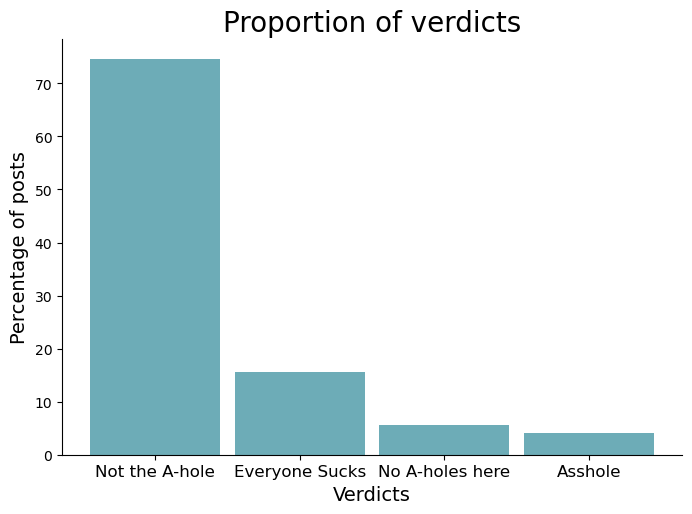

In [130]:
## plotting
plt.figure(figsize=(8,5.5), dpi=100)
plt.bar(ind, pctg_verdicts, width, label = "Percentage of posts", color=(0.33, 0.62, 0.67, 0.85))

plt.ylabel('Percentage of posts', fontsize=14)
plt.xlabel('Verdicts', fontsize=14)
plt.title('Proportion of verdicts', fontsize=20)
locations = ticks
plt.xticks(locations, legends, fontsize=12)
plt.yticks()
sns.despine();

### Removed and deleted posts proportion

A very usual concern when posting is being found by people you know on Reddit, or sometimes you post something and get hit with the overwhelming feel of shame that you want to delete your existence off the internet (though if it's on the Internet, it'll stay there forever!), so you try to at least clear your Reddit traces. Sometimes, your content doesn't fulfill subreddit standards and mods delete your post, to avoid clutter. There might be a few reasons, but the reality is that a lot of posts get removed by users or mods, so we tried to take a closer look at this missing posts, using both the original dataframe. 

When checking, we find over 100k posts (which were removed from the original dataset for other analysis) which don't have neither a flair or body. The removed body posts are invalid submissions cleaned by mods or automods. The deleted submissions represents those removed by the original poster, which are a much less in comparison.

The proportions of deleted posts are similar for all verdicts and slightly higher for the more positive verdicts, so apparently people who are deemed A-holes by Redditors are not into removing their content after all!

In [131]:
df.query("verdict.isnull() & body in ['[removed]', '[deleted]']",engine='python').body.value_counts()

[removed]    108722
[deleted]      3647
Name: body, dtype: int64

In [132]:
total_posts = clean_df.verdict.value_counts()
deleted_posts = clean_df.query("body == '[deleted]'").verdict.value_counts()
total_posts / deleted_posts

Not the A-hole     10.977704
Asshole             8.017316
No A-holes here     9.375000
Everyone Sucks      8.488636
Name: verdict, dtype: float64

### Time distribution of posts

When looking at distribution of valid posts based of when they were posted, we some clear find some patterns. First, the distribution based on hour of day (UTC) reached its peak during afternoon hours, and slowly decreases until its lowest point at 6AM. Even when considering timezones, we can see that people are posting a lot more during school/work hours rather than nighttime, which could have been expected if we consider the typical night-owl stereotype. 

For week distribution, the time range considered is from late August to end of year, so we'd cover Thanksgiving (ISO Week 47) and Christmas (ISO Week 51), which are indeed the busiest weeks in our range, and matches with the usual background stories for AITA posts.

In [133]:
hour_distribution = clean_df.groupby('hour_of_day').id.count().values

In [134]:
## general parameters for plotting
legends = clean_df.groupby('hour_of_day').id.count().index
ind = np.arange(len(hour_distribution))
ticks = np.arange(len(legends))
width = 0.65

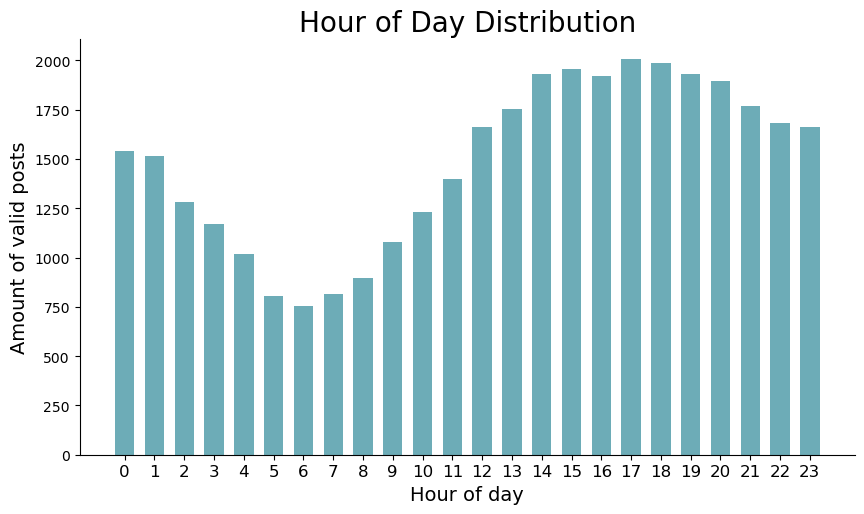

In [135]:
## plotting
plt.figure(figsize=(10,5.5), dpi=100)
plt.bar(ind, hour_distribution, width, label = "Percentage of posts", color=(0.33, 0.62, 0.67, 0.85))

plt.ylabel('Amount of valid posts', fontsize=14)
plt.xlabel('Hour of day', fontsize=14)
plt.title('Hour of Day Distribution', fontsize=20)
locations = ticks
plt.xticks(locations, legends, fontsize=12)
plt.yticks()
sns.despine();

In [136]:
week_distribution = clean_df.groupby('isoweek').id.count().values

In [137]:
## general parameters for plotting
legends = clean_df.groupby('isoweek').id.count().index
ind = np.arange(len(week_distribution))
ticks = np.arange(len(legends))
width = 0.8

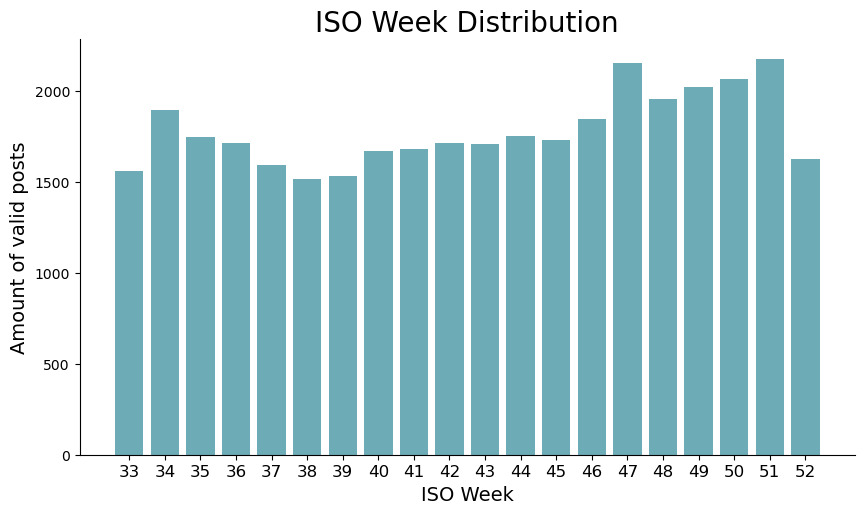

In [138]:
## plotting
plt.figure(figsize=(10,5.5), dpi=100)
plt.bar(ind, week_distribution, width, label = "Percentage of posts", color=(0.33, 0.62, 0.67, 0.85))

plt.ylabel('Amount of valid posts', fontsize=14)
plt.xlabel('ISO Week', fontsize=14)
plt.title('ISO Week Distribution', fontsize=20)
locations = ticks
plt.xticks(locations, legends, fontsize=12)
plt.yticks()
sns.despine();

### Number of comments and upvotes

When looking at descriptive statistics of the numerical fields, we can see that, in average, posts with YTA and ESH verdicts have higher number of comments than NTA and NAH, which could be due to people wanting to voice their opinions more on situations where you want to tell the OPs they're wrong, or because longer discussions start in the comment sections. On a similar note, the scores and upvote ratios are lower in YTA than the rest of the verdicts, which is also related to the previous point, as people will downvote posts where people are being AHs.

In [139]:
clean_df.groupby("verdict").describe().transpose()

verdict                  Asshole  Everyone Sucks  No A-holes here  \
score        count   5556.000000     1494.000000      2025.000000   
             mean     539.046436      327.498661       158.789630   
             std     2056.536772     1352.262357       773.826195   
             min        0.000000        0.000000         0.000000   
             25%        5.000000        4.000000         4.000000   
             50%       15.000000        9.000000         8.000000   
             75%       59.000000       34.000000        24.000000   
             max    25186.000000    15723.000000     15260.000000   
upvote_ratio count   5556.000000     1494.000000      2025.000000   
             mean       0.700734        0.745207         0.758726   
             std        0.153435        0.148418         0.138937   
             min        0.130000        0.170000         0.250000   
             25%        0.620000        0.650000         0.670000   
             50%        0.710000        0.760000         0.780000   
             75%        0.820000        0.867500         0.870000   
             max        1.000000        1.000000         1.000000   
num_comments count   5556.000000     1494.000000      2025.000000   
             mean     208.407847      114.285810        59.793086   
             std      602.575620      409.733118       231.239759   
             min        3.000000        3.000000         3.000000   
             25%       24.000000       16.000000        13.000000   
             50%       44.000000       27.000000        23.000000   
             75%      103.000000       54.000000        41.000000   
             max     8065.000000     7977.000000      5836.000000   
hour_of_day  count   5556.000000     1494.000000      2025.000000   
             mean      12.936105       12.769076        12.892346   
             std        6.950051        6.923335         6.858844   
             min        0.000000        0.000000         0.000000   
             25%        8.000000        8.000000         8.000000   
             50%       14.000000       14.000000        14.000000   
             75%       19.000000       19.000000        18.000000   
             max       23.000000       23.000000        23.000000   
isoweek      count   5556.000000     1494.000000      2025.000000   
             mean      42.835133       43.062918        42.761481   
             std        5.829331        5.875699         5.823227   
             min       33.000000       33.000000        33.000000   
             25%       38.000000       38.000000        38.000000   
             50%       43.000000       44.000000        43.000000   
             75%       48.000000       48.000000        48.000000   
             max       52.000000       52.000000        52.000000   

verdict             Not the A-hole  
score        count    26588.000000  
             mean       745.298180  
             std       2511.693064  
             min          0.000000  
             25%          7.000000  
             50%         20.000000  
             75%        178.000000  
             max      41160.000000  
upvote_ratio count    26588.000000  
             mean         0.829919  
             std          0.130107  
             min          0.140000  
             25%          0.750000  
             50%          0.860000  
             75%          0.940000  
             max          1.000000  
num_comments count    26588.000000  
             mean       118.523996  
             std        337.745845  
             min          2.000000  
             25%         16.000000  
             50%         28.000000  
             75%         64.000000  
             max       5810.000000  
hour_of_day  count    26588.000000  
             mean        12.793290  
             std          6.882509  
             min          0.000000  
             25%          8.000000  
             50%         14.000000  
             75%       

In [140]:
num_comments = clean_df.groupby("verdict").num_comments.mean()

In [141]:
## general parameters for plotting
legends = upvote_ratio.index
ind = np.arange(len(upvote_ratio))
ticks = np.arange(len(legends))
width = 0.7

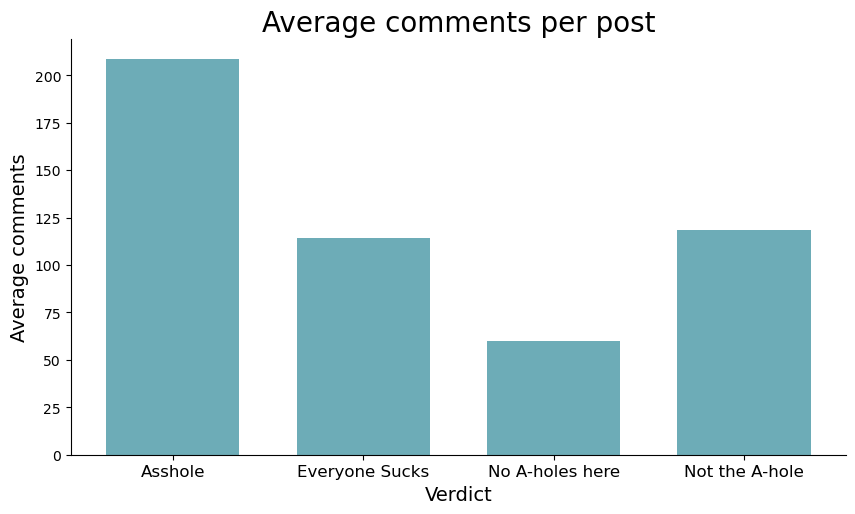

In [142]:
## plotting
plt.figure(figsize=(10,5.5), dpi=100)
plt.bar(ind, num_comments, width, label = "Comments", color=(0.33, 0.62, 0.67, 0.85))

plt.ylabel('Average comments', fontsize=14)
plt.xlabel('Verdict', fontsize=14)
plt.title('Average comments per post', fontsize=20)
locations = ticks
plt.xticks(locations, legends, fontsize=12)
plt.yticks()
sns.despine();

### Word Clouds

As an extra, and to compare the most used words in our two opposite sides: YTA and NTA verdicts, we'll create some word clouds images for both classes, and see what we can find. First, we'll create the files necessary for the script, running the following cells, and then we can run the script from the main folder, running `python wordclouds/wordcloud_builder.py`

In [143]:
nta_df = clean_df.query("verdict == 'Not the A-hole'").sort_values(by="num_comments", ascending=False).head(500)

In [144]:
yta_df = clean_df.query("verdict == 'Asshole'").sort_values(by="num_comments", ascending=False).head(500)

In [149]:
nta_text = []

for text in nta_df.body.values:
    with open(os.path.join("wordclouds/nta_text.txt"), "a+") as f:
        f.write(text)

In [150]:
yta_text = []

for text in yta_df.body.values:
    with open(os.path.join("wordclouds/yta_text.txt"), "a+") as f:
        f.write(text)

<a id="discussion"></a>
## Discussion
This project represents the end of the Nanodegree, and was created from scratch thinking of something that could be both fun and could provide insight from a popular website that I personally browse everyday. It was challenging, and tries to cover a little bit of everything learned through this course. 

The dataset was obtained from scratch using Reddit APIs, which was a whole world to explore on its own and took a lot of testing to get the information with the desired format and using the right filters. Thanks to this, the dataset required minimal cleaning steps, mostly for formatting issues, as it was designed and then retrieved from the API with the project in mind. This process required some iteration regarding the size of the dataset, because over 3/4 of the original posts were removed as they had an invalid or null flair, so the script was modified until a better sample size was gathered for the smaller classes.

The machine learning pipeline was similar to what was covered during the course, but proved to be even more rewarding when using original data and iterating through the script to improve its metrics for a better model. The original dataset was biased towards a particular verdict, so several things were tested before the final version which improved its metrics from the first one. A few things were implemented, like accounting for imbalaced classes, trying different dataset sizes, trying two classifiers (AdaBoostClassifier and RandomForestClassifier) and looking through different parameters to test with GridSearch. In the end, the model had higher metrics, and since the classes were balanced, the accuracy improved overall. It's not perfect (yet), due to the complexity of this challenge, which might be a bit ambitious in wanting to classify based on internet users' moral compass, which is an issue on its own.

As for analytical results, we were able to visualize a few different trends regarding behaviour around these posts, like the comment activity and willingness to delete your own posts based on verdicts. 

<a id="tester"></a>
## Model Tester